# Computer Simulation Project - Phase 2
#### yashar paymai 401100325

# 1. Introduction

In this phase, we simulate a modern medical center using queueing theory. This center employs robotic technology to enhance patient service, particularly for individuals with disabilities.

Patients arrive at the center according to a specific distribution. Each patient may have a disability, which can be one of three types. Furthermore, each patient has a designated destination. Both disability and destination influence the service time.

## 2. Input Parameters

* **2.1 Arrival Process:**
  The time between consecutive arrivals follows an exponential distribution with parameter λ: 
    $$f(t) = \lambda e^{-\lambda t}, \quad t \geq 0$$
  

* **2.2 Disability Status:**
Each visitor has an X% chance of having a disability. The disability type is uniformly distributed among three states:
 $$P(\text{disability type} = i) = \frac{1}{3}, \quad i \in \{1, 2, 3\}$$

## 3. System Structure

* **3.1 Standard State:**
In the standard state, there are two human servers with service times according to Table 1. Upon arrival, patients join the shortest queue. If both queues are empty, the patient joins a random server.

* **3.2 Robotic State:**
In the robotic state:
  * Server 1: Standard service with time according to the table.
  * Server 2 (Robot): Provides service similar to non-disabled individuals and serves disabled individuals with a time α times the table value. Priority is given to disabled individuals and then by arrival time.
  * Non-disabled patients choose a server as in the standard state. Disabled patients choose the robotic server.

## 4. Service Time

Service time depends on destination, disability, and the presence of a robot. In the absence of a robot, times are according to Table 1. With a robot, service time for disabled individuals is α times the normal time.

| Disability Type | Destination | Time |
|---|---|---|
| 1 | A | 8 |
| 1 | B | 10 |
| 2 | A | 10 |
| 2 | B | 14 |
| 3 | A | 18 |
| 3 | B | 16 |
| None | A | 4 |
| None | B | 6 |

**Table 1: Service time for disabled individuals**

## 5. Error Model

Service times are subject to a random variable. Each server has a probability p of making an error and repeating the service.

## 6. Performance Metrics

* `E[Lq]`: Average queue length
* `E[Wq]`: Average waiting time
* `E[W]`: Average total time in the system

## 7. Simulation Parameters

Adjustable variables in the simulation:

* T: Total simulation time
* X: Percentage of individuals with disabilities
* α: Reduction factor for service time in the robotic server
* p: Probability of error in each service
* p1: Probability of destination 1

## 8. Simulation Method

For each set of parameters, the system is simulated as follows:

1. Generate arrival times with an exponential distribution.
2. Randomly assign disability status and service type.
3. Run the simulation with priority rules.
4. Calculate performance metrics.
5. Repeat for statistical stability.

## 9. Expected Outputs

* Comparison of average waiting time in standard and robotic states
* Sensitivity analysis with respect to different parameters
* Analysis of the effect of error probability on system performance
* Evaluation of the efficiency of prioritizing disabled individuals

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

In [35]:
"""
MinHeap class for accessing events based on time
"""


class MinHeap:
    def __init__(self):
        self.heap = []

    def push(self, item):
        heapq.heappush(self.heap, item)

    def pop(self):
        return heapq.heappop(self.heap)

    def get_min(self):
        return self.heap[0]

    def is_empty(self):
        return len(self.heap) == 0


In [36]:
class Patient:
    """
    Patient class with attributes :
    id : unique identifier for a patient
    enter_time : time when patient enters the system
    num_attempt : number of times service is failed for a patient before success. we could consider this attribute in Server class but as the p_error is same in both
    servers for simplicity we consider it in Patient class.
    patient_type : type of patient (0 : normal, 1,2,3 : disable)
    destination : destination of patient (1 : server1, 2 : server2)
    service_time : time to serve a patient based on patient_type and destination without considering num_attempt and alpha
    actual_service_time : actual service time for a patient considering service_time, num_attempt and alpha during simulation
    exit_time : time when patient leaves the system
    wait_time : total time spent by a patient in the system (wait_time = exit_time - enter_time)
    wait_q_time : time spent by a patient in the queue (wait_q_time = enter_service - enter_time or wait_q_time = wait_time - actual_service_time)
    server_id : id of server serving the patient (1 or 2)
    """

    def __init__(self, id, enter_time, patient_type, destination, num_attempt, service_time):
        self.id = id
        self.enter_time = enter_time
        self.num_attempt = num_attempt
        self.patient_type = patient_type
        self.destination = destination
        self.service_time = service_time
        self.actual_service_time = None
        self.exit_time = None
        self.wait_time = None
        self.wait_q_time = None
        self.server_id = None

    def __str__(self):
        return f'Patient {self.id} : enter_time = {self.enter_time:.3f}, patient_type = {self.patient_type}, destination = {self.destination}, num_attempt = {self.num_attempt}, service_time = {self.service_time:.3f}, actual_service_time = {self.actual_service_time:.3f}, exit_time = {self.exit_time:.3f}, wait_time = {self.wait_time:.3f}, wait_q_time = {self.wait_q_time:.3f}, server_id = {self.server_id}'

    def set_exit_time(self, exit_time):
        self.exit_time = exit_time
        self.wait_time = self.exit_time - self.enter_time

    def set_enter_service(self, enter_service):
        self.wait_q_time = enter_service - self.enter_time

    def set_server_id(self, server_id):
        self.server_id = server_id

    def set_actual_service_time(self, actual_service_time):
        self.actual_service_time = actual_service_time

In [37]:


class Server:
    """
    Server class with attributes :
    id : unique identifier for a server (1 or 2 in this case)
    priority_type : list of patient types which are considered as priority_type for a server. patients of these types are served first despite their arrival time.
    queue : list of patients in the queue
    priority_queue : list of patients in the queue with priority_type 
    (we consider a separate queue for priority_type patients for simplicity in accessing priority_type patients without using any sorting or data structure)
    alpha : parameter to control the service time of priority_type patients
    """

    def __init__(self, id, priority_type, alpha=1.0):
        self.id = id
        self.priority_type = priority_type
        self.queue = []
        self.priority_queue = []
        self.alpha = alpha

    def __str__(self):
        return f'Server {self.id} : busy = {len(self.queue) + len(self.priority_queue) > 0}, priority_type = {self.priority_type}, len total queue = {len(self.queue) + len(self.priority_queue)}, len priority queue = {len(self.priority_queue)}'

    def add_patient(self, patient):
        if patient.patient_type in self.priority_type:
            self.priority_queue.append(patient)
        else:
            self.queue.append(patient)

    def remove_patient(self, patient_type):
        if patient_type in self.priority_type:
            self.priority_queue.pop(0)
        else:
            self.queue.pop(0)

    def get_len_queue(self):
        return len(self.queue) + len(self.priority_queue)





In [38]:
"""
time_table : dictionary to store service time for each patient_type and destination based on the project description
pair (patient_type, destination) is used as key to access service time for a patient
"""
time_table = {(0, 1): 4.0, (0, 2): 6.0,
              (1, 1): 8.0, (1, 2): 10.0,
              (2, 1): 10.0, (2, 2): 14.0,
              (3, 1): 18.0, (3, 2): 16.0}

"""
function to generate enter times for patients based on exponential distribution with parameter lambd.
we generate enter times while last_enter_time is less than T.
"""


def enter_times(T, lambd):
    last_enter_time = 0.0
    enter_times = []
    while last_enter_time < T:
        last_enter_time += np.random.exponential(1 / lambd)
        enter_times.append(last_enter_time)
    return enter_times[:len(enter_times) - 1]


"""
function to generate patients based on enter times, lambd, p_disable, p_dest and p_error
at first we generate enter times for patients based on exponential distribution with parameter lambd
then for each patient we generate patient_type, destination, num_attempt and service_time based on p_disable, p_dest and p_error
patient_type : with probability 1 - p_disable, patient is type 0 otherwise with equal probability type 1,2,3
destination : with probability 1 - p_dest, destination is 1 otherwise with equal probability 2
n_attempt : number of times service is failed for a patient before success. we consider a Geometric distribution with parameter 1 - p_error
service_time : time to serve a patient based on patient_type and destination
"""


def generate_patients(T, lambd, p_disable=0, p_dest=0, p_error=0):
    enter_times_ = enter_times(T, lambd)
    patients = []
    for i, enter_time in enumerate(enter_times_):
        patient_type = 0 if np.random.uniform(0, 1) > p_disable else np.random.randint(1, 4)

        destination = 1 if np.random.uniform(0, 1) > p_dest else 2

        n_attempt = np.random.geometric(1 - p_error)

        service_time = time_table[(patient_type, destination)]

        cur_patient = Patient(id=i, enter_time=enter_time, patient_type=patient_type, destination=destination,
                              num_attempt=n_attempt, service_time=service_time)

        patients.append(cur_patient)

    return patients

In [61]:
"""
function to simulate the system based on patients, lambd, p_disable, p_dest, p_error, disabled_server, alpha, log, print_statistics
patients : list of patients generated based on generate_patients function
lambd : parameter for exponential distribution to generate enter times for patients
p_disable : probability to disable a server
p_dest : probability to choose destination 1
p_error : probability of error in service
disabled_server : if True, we consider server 2 as disabled server with priority_type [1, 2, 3] and alpha , otherwise we consider server 2 as normal server
alpha : parameter to control the service time of priority_type patients
log : if True, we print patients and servers information during simulation , mostly for debugging purpose
print_statistics : if True, we print statistics after simulation
"""


def simulate(T, lambd, p_disable, p_dest, p_error, disabled_server=False, alpha=1.0, log=False, print_statistics=False,
             priority_to_disabled=True):
    """generate patients based on parameters"""
    patients = generate_patients(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error)

    if log:
        print("Patients : ")
        for patient in patients:
            print(patient)

    """
    initialize servers
    server 1 : normal server
    server 2 : server with priority_type [1, 2, 3] if disabled_server is True, otherwise normal server
    """
    servers = [None, None]
    servers[0] = Server(id=1, priority_type=[])
    if disabled_server:
        servers[1] = Server(id=2, priority_type=[1, 2, 3], alpha=alpha)
    else:
        servers[1] = Server(id=2, priority_type=[])

    if log:
        print("Servers : ")
        for server in servers:
            print(server)

    """
    events : min heap to store events based on time
    each event is a tuple of (time, event_type, patient_id)
    event_type : arrival or departure of a patient
    """
    events = MinHeap()

    """as we have only arrival events at the beginning, we push all arrival events to the heap and other events are pushed during simulation"""
    for patient in patients:
        events.push((patient.enter_time, "arrival", patient.id))

    """simulating the system until all events are processed"""
    while not events.is_empty():
        if log:
            print("#####################################################################\n")
        if log:
            for server in servers:
                print(server)

        """get the next event based on time"""
        cur_time, event_type, patient_id = events.pop()
        cur_patient = patients[patient_id]

        if event_type == "arrival":
            if log:
                print(f"Time : {cur_time:.3f}, Event : Arrival, Patient : {cur_patient}")
            """
            first we decide the server for the patient based on priority_type and length of queue in servers
            if patient is in priority_type of any server, we select that server
            otherwise we select the server with minimum length of queue and if equal we select randomly
            """
            selected_server = 0
            for server in servers:
                if cur_patient.patient_type in server.priority_type:
                    selected_server = server.id
            if selected_server == 0:
                selected_server = np.random.randint(1, 3)
                for server in servers:
                    if server.get_len_queue() < servers[selected_server - 1].get_len_queue():
                        selected_server = server.id

            cur_patient.set_server_id(selected_server)
            servers[selected_server - 1].add_patient(cur_patient)

            if log:
                print(f"Selected Server : {selected_server}")

            """
            if server is not busy, we schedule departure event for the patient now
            we consider the actual service time for the patient based on alpha and priority_type
            actual service time = service_time * num_attempt * beta
            where beta = alpha if patient_type in priority_type of server else 1.0
            then we schedule departure event for the patient after actual service time
            """
            if servers[selected_server - 1].get_len_queue() <= 1:
                beta = servers[selected_server - 1].alpha if cur_patient.patient_type in servers[
                    selected_server - 1].priority_type else 1.0
                cur_patient.set_actual_service_time((cur_patient.service_time * cur_patient.num_attempt) * beta)
                cur_patient.set_enter_service(cur_time)
                events.push((cur_time + cur_patient.actual_service_time, "departure",
                             cur_patient.id))


        elif event_type == "departure":
            if log:
                print(f"Time : {cur_time:.3f}, Event : Departure, Patient : {cur_patient}")
                print(f"Customer {cur_patient.id} has left the system after {cur_patient.num_attempt} attempts.")

            """
            first we remove the patient from the server and if there are patients in the queue,
            we select the next patient and schedule departure event for the next patient
            """
            cur_server = servers[cur_patient.server_id - 1]
            cur_server.remove_patient(cur_patient.patient_type)
            if cur_server.get_len_queue() > 0:
                """
                this option is for last part of the project where we consider priority_to_disabled parameter
                """
                if not priority_to_disabled:
                    if len(cur_server.queue) > 0:
                        next_patient = cur_server.queue[0]
                        if len(cur_server.priority_queue) > 0 and next_patient.enter_time > cur_server.priority_queue[0].enter_time:
                            next_patient = cur_server.priority_queue[0]
                    else:
                        next_patient = cur_server.priority_queue[0]
                else : 
                    if len(cur_server.priority_queue) > 0:
                        next_patient = cur_server.priority_queue[0]
                    else:
                        next_patient = cur_server.queue[0]
                beta = cur_server.alpha if next_patient.patient_type in cur_server.priority_type else 1.0
                next_patient.set_actual_service_time((next_patient.service_time * next_patient.num_attempt) * beta)
                next_patient.set_enter_service(cur_time)
                events.push((cur_time + next_patient.actual_service_time, "departure",
                             next_patient.id))
            cur_patient.set_exit_time(cur_time)

    """after all events are processed, we calculate statistics"""

    """total_system_run_time : time when last patient leaves the system"""
    total_system_run_time = max([patient.exit_time for patient in patients])

    """calculate number of normal and disable patients in the system"""
    num_normal = len([patient for patient in patients if patient.patient_type == 0])
    num_disable = len([patient for patient in patients if patient.patient_type != 0])

    """
    now we calculate average wait times (W , Wq) for normal and disable patients.
    for example for normal patients, average_wait_time_normal = sum(wait_time for normal patients) / (number of normal patients)
    and average_wait_time_q_normal = sum(wait_q_time for normal patients) / (number of normal patients)
    """
    average_wait_time_normal = 0.0
    average_wait_time_disable = 0.0
    average_wait_time_q_normal = 0.0
    average_wait_time_q_disable = 0.0

    for patient in patients:
        if patient.patient_type == 0:
            average_wait_time_normal += patient.wait_time
            average_wait_time_q_normal += patient.wait_q_time
        else:
            average_wait_time_disable += patient.wait_time
            average_wait_time_q_disable += patient.wait_q_time

    average_wait_time_normal /= num_normal if num_normal > 0 else 1
    average_wait_time_disable /= num_disable if num_disable > 0 else 1
    average_wait_time_q_normal /= num_normal if num_normal > 0 else 1
    average_wait_time_q_disable /= num_disable if num_disable > 0 else 1

    """
    now we calculate average queue length for server 1 and server 2
    average_queue_length_server1 = sum(wait_q_time for patients in server 1) / total_system_run_time
    average_queue_length_server2 = sum(wait_q_time for patients in server 2) / total_system_run_time
    """

    average_queue_length_server1 = 0.0
    average_queue_length_server2 = 0.0

    for patient in patients:
        if patient.server_id == 1:
            average_queue_length_server1 += patient.wait_q_time
        else:
            average_queue_length_server2 += patient.wait_q_time

    average_queue_length_server1 /= total_system_run_time
    average_queue_length_server2 /= total_system_run_time

    """
    and finally we calculate server utilization for server 1 and server 2
    sever1_utilization = sum(actual_service_time for patients in server 1) / total_system_run_time
    sever2_utilization = sum(actual_service_time for patients in server 2) / total_system_run_time
    """

    sever1_utilization = sum(
        [patient.actual_service_time for patient in patients if patient.server_id == 1]) / total_system_run_time
    sever2_utilization = sum(
        [patient.actual_service_time for patient in patients if patient.server_id == 2]) / total_system_run_time

    """
    now we make a dictionary of statistics and return it as simulation result
    """

    statistics = {"total_system_run_time": total_system_run_time,
                  "average_wait_time_normal": average_wait_time_normal,
                  "average_wait_time_disable": average_wait_time_disable,
                  "average_wait_time_q_normal": average_wait_time_q_normal,
                  "average_wait_time_q_disable": average_wait_time_q_disable,
                  "average_queue_length_server1": average_queue_length_server1,
                  "average_queue_length_server2": average_queue_length_server2,
                  "num_normal": num_normal,
                  "num_disable": num_disable,
                  "sever1_utilization": sever1_utilization,
                  "sever2_utilization": sever2_utilization
                  }

    if log or print_statistics:
        print("Statistics : ")
        for key, value in statistics.items():
            print(f"{key} : {value:.3f}")

    return statistics

In [40]:
"""
average_service_time_analytical function to calculate average service time based on p_disable, p_dest, p_error and alpha analytically based on time_table 
we use this function to have a starting point for setting lambd in simulation
theoretically if we don't consider the effect of greedy policies(patients choose the server with minimum queue length and also server2 policy for priority_type patients) 
the system should be stable when lamdb is less than or around (number of servers)/(average service time) which is in this case 2/(average service time)
so using this function we can have an good estimation for interval of lambd
"""


def average_service_time_analytical(p_disable, p_dest, p_error, alpha=1.0):
    service_time = 0
    service_time += 1 / 3 * p_disable * p_dest * 1 / (1 - p_error) * (
            time_table[(1, 1)] + time_table[(2, 1)] + time_table[(3, 1)])
    service_time += 1 / 3 * p_disable * (1 - p_dest) * 1 / (1 - p_error) * (
            time_table[(1, 2)] + time_table[(2, 2)] + time_table[(3, 2)])
    service_time *= alpha
    service_time += (1 - p_disable) * p_dest * 1 / (1 - p_error) * (time_table[(0, 1)])
    service_time += (1 - p_disable) * (1 - p_dest) * 1 / (1 - p_error) * (time_table[(0, 2)])
    return service_time

In [41]:
"""
function to compare simulation results for N times and return average statistics for normal and robot assisted servers
"""


def compare_simulation(N, T, lambd, p_disable, p_dest, p_error, alpha=1.0, print_statistics=False):
    average_statistics_normal = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                                         disabled_server=False, alpha=alpha, log=False, print_statistics=False)
    for i in range(N - 1):
        statistics = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                              disabled_server=False, alpha=alpha, log=False, print_statistics=False)
        for key, value in statistics.items():
            average_statistics_normal[key] += value

    average_statistics_robot = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                                        disabled_server=True, alpha=alpha, log=False, print_statistics=False)
    for i in range(N - 1):
        statistics = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                              disabled_server=True, alpha=alpha, log=False, print_statistics=False)
        for key, value in statistics.items():
            average_statistics_robot[key] += value

    for key, value in average_statistics_normal.items():
        average_statistics_normal[key] /= N
    for key, value in average_statistics_robot.items():
        average_statistics_robot[key] /= N

    if print_statistics:
        print("Average Statistics Normal : ")
        for key, value in average_statistics_normal.items():
            print(f"{key} : {value:.3f}")
        print("\n")
        print("Average Statistics Robot : ")
        for key, value in average_statistics_robot.items():
            print(f"{key} : {value:.3f}")

    return average_statistics_normal, average_statistics_robot

**We first set parameters as follows :**

* N = 100
* T = 1440
* p_disable = 0.2
* p_dest = 0.5
* p_error = 0.3
* alpha = 0.7

**Also we calculate average service time analytically based on the parameters for setting a logical value for lambd in simulation**



In [42]:
N = 100
T = 1440
p_disable = 0.2
p_dest = 0.5
p_error = 0.3
alpha = 0.7

Average_service_time_normal = average_service_time_analytical(p_disable, p_dest, p_error)
Average_service_time_robot = average_service_time_analytical(p_disable, p_dest, p_error, alpha=alpha)

print(f"Average Service Time Normal : {Average_service_time_normal:.3f}")
print(f"Average Service Time Robot : {Average_service_time_robot:.3f}")
lambda_normal = 2 / Average_service_time_normal
lambda_robot = 2 / Average_service_time_robot

print(f"Lambda Normal : {lambda_normal:.3f}")
print(f"Lambda Robot : {lambda_robot:.3f}")

Average Service Time Normal : 9.333
Average Service Time Robot : 8.248
Lambda Normal : 0.214
Lambda Robot : 0.242


**so we set lambd = 0.21 to see different statistics for normal and robot servers in a relatively normal situation.**

In [43]:
lambd = 0.21

average_statistics_normal1, average_statistics_robot1 = compare_simulation(N, T, lambd, p_disable, p_dest, p_error,
                                                                           alpha=alpha, print_statistics=True)

Average Statistics Normal : 
total_system_run_time : 1532.244
average_wait_time_normal : 53.394
average_wait_time_disable : 64.123
average_wait_time_q_normal : 46.283
average_wait_time_q_disable : 45.945
average_queue_length_server1 : 4.578
average_queue_length_server2 : 4.572
num_normal : 243.440
num_disable : 60.600
sever1_utilization : 0.923
sever2_utilization : 0.926


Average Statistics Robot : 
total_system_run_time : 1468.978
average_wait_time_normal : 26.908
average_wait_time_disable : 25.137
average_wait_time_q_normal : 19.798
average_wait_time_q_disable : 12.449
average_queue_length_server1 : 1.583
average_queue_length_server2 : 2.247
num_normal : 241.980
num_disable : 59.460
sever1_utilization : 0.796
sever2_utilization : 0.888


| Metric | Normal | Robot |
|---|---|---|
| Total System Run Time | 1516.909 | 1472.312 |
| Average Wait Time (Normal) | 50.458 | 25.681 |
| Average Wait Time (Disabled) | 60.7 | 24.515 |
| Average Wait Time in Queue (Normal) | 43.303 | 18.557 |
| Average Wait Time in Queue (Disabled) | 42.734 | 12.034 |
| Average Queue Length (Server 1) | 4.306 | 1.448 |
| Average Queue Length (Server 2) | 4.298 | 2.107 |
| Number of Normal Devices | 239.5 | 241.28 |
| Number of Disabled Devices | 60.23 | 59.76 |
| Server 1 Utilization | 0.921 | 0.788 |
| Server 2 Utilization | 0.92 | 0.886 |


**We observe a significant decrease in Wq , W for both normal and disabled patients(especially disabled patients) when using the robot server.
also a significant decrease in L in both servers.
about the server utilization, we see that in normal servers utilization is almost the same , but in the robot servers utilization of server 1 is less that server 2 , 
it is because that disabled patients are served by server 2 only.**


In [44]:
"""
function to plot statistics for normal and robot servers based on changing parameter
"""


def plot_function(changing_params, average_statistics_normals, average_statistics_robots, param_label='X',
                  special_points=[]):
    statistics = average_statistics_normals[0].keys()
    for statistic in statistics:
        plt.figure()
        plt.title(statistic)
        plt.plot(changing_params,
                 [average_statistics_normal[statistic] for average_statistics_normal in average_statistics_normals],
                 label='Normal')
        plt.plot(changing_params,
                 [average_statistics_robot[statistic] for average_statistics_robot in average_statistics_robots],
                 label='Robot')
        for point in special_points:
            plt.axvline(x=point, color='r', linestyle='--')
        plt.xlabel(param_label)
        plt.ylabel(statistic)
        plt.legend()
        plt.show()

**Now we consider diffrent values for lambd to see the effect of arrival rate on system performance.
we consider lambd in the range [0.16, 0.26] and plot the statistics.
also we consider special points lambd_normal = 0.214 and lambd_robot = 0.242 .**

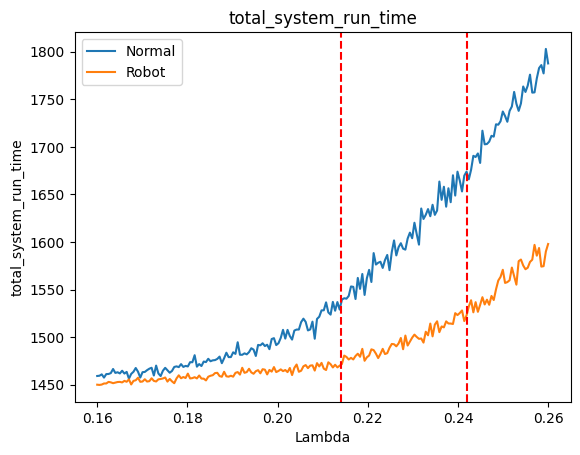

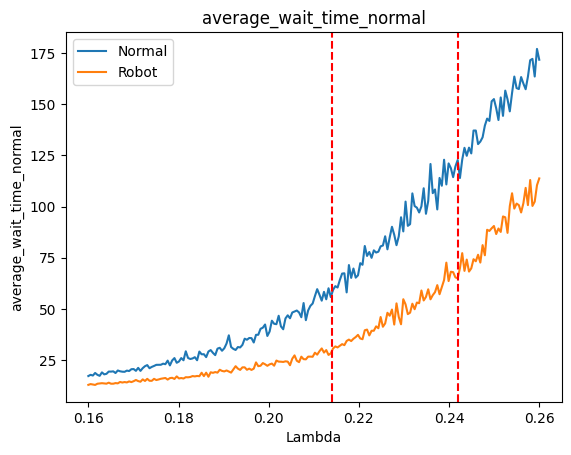

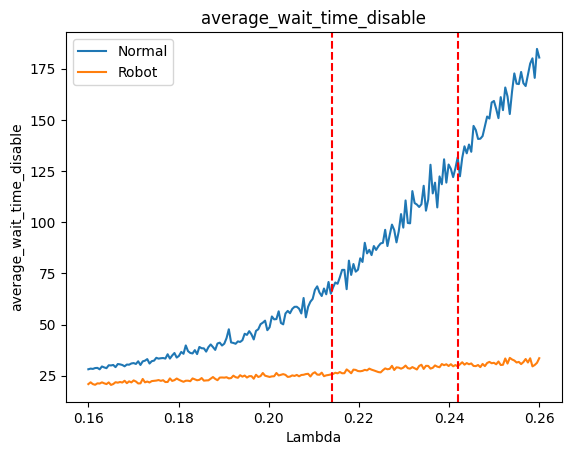

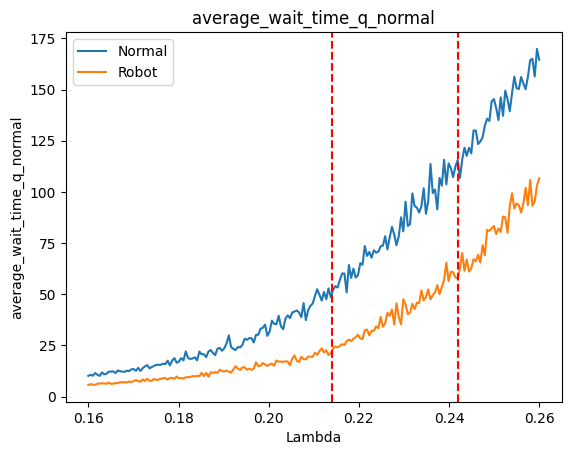

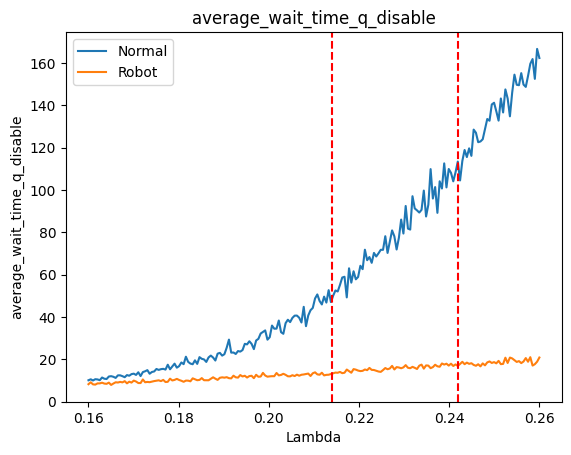

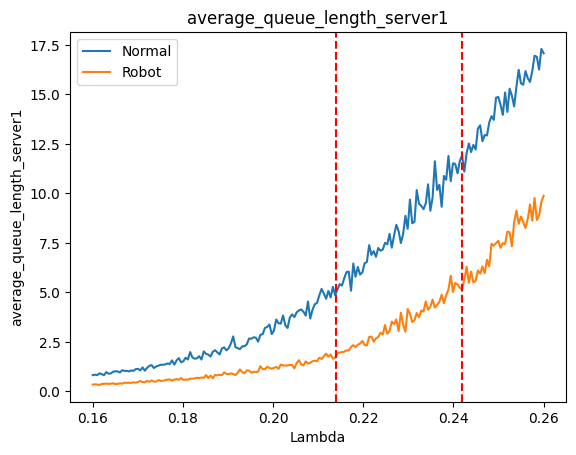

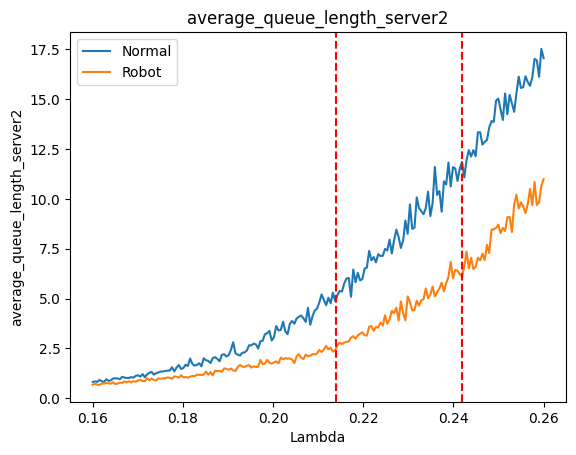

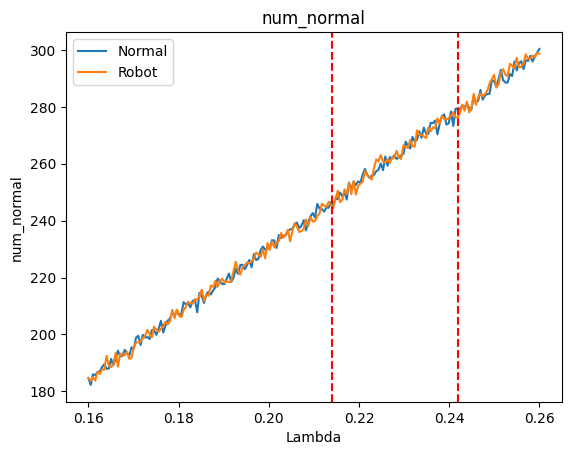

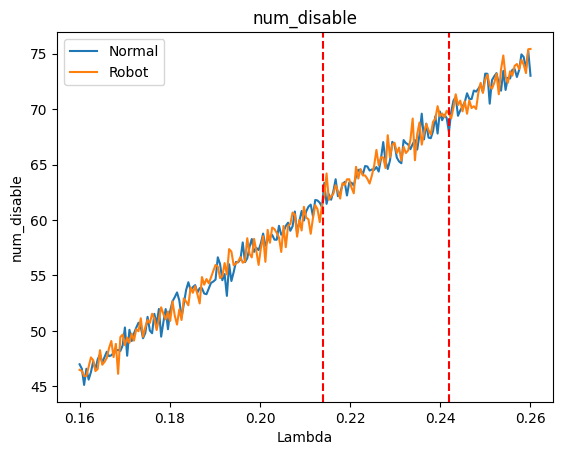

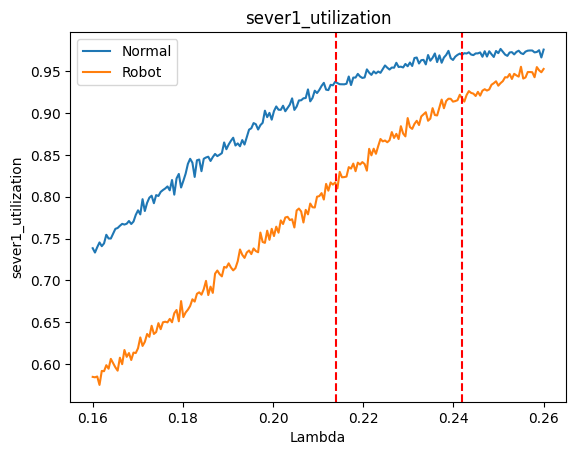

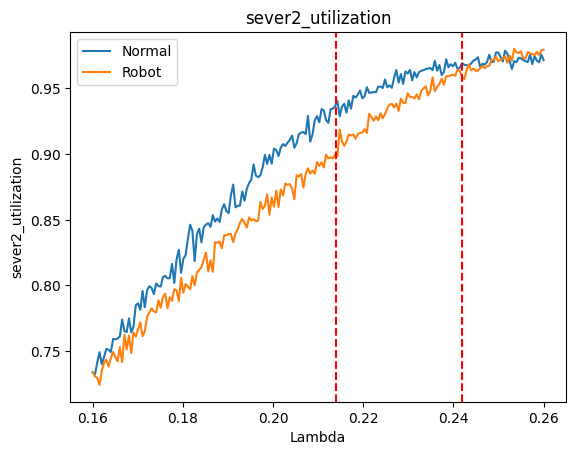

In [45]:
N = 100
T = 1440
p_disable = 0.2
p_dest = 0.5
p_error = 0.3
alpha = 0.7

special_points = [0.214, 0.242]

lambds = np.linspace(0.16, 0.26, 200)

average_statistics_normals = []
average_statistics_robots = []

for lambd in lambds:
    average_statistics_normal, average_statistics_robot = compare_simulation(N, T, lambd, p_disable, p_dest, p_error,
                                                                             alpha=alpha, print_statistics=False)
    average_statistics_normals.append(average_statistics_normal)
    average_statistics_robots.append(average_statistics_robot)

plot_function(lambds, average_statistics_normals, average_statistics_robots, param_label='Lambda',
              special_points=special_points)


##TODO

**now we consider all parameters constant and change p_disable in the range [0.0, 1.0]**

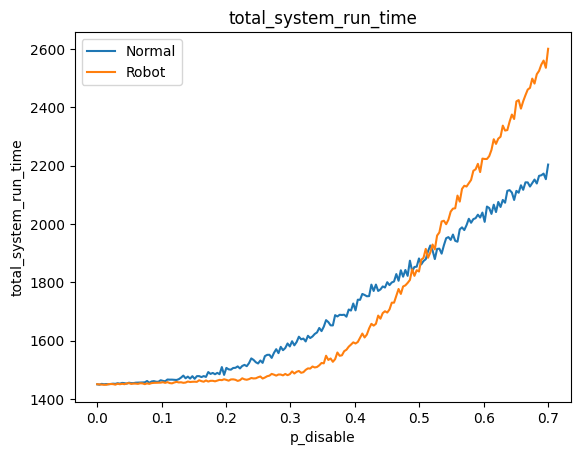

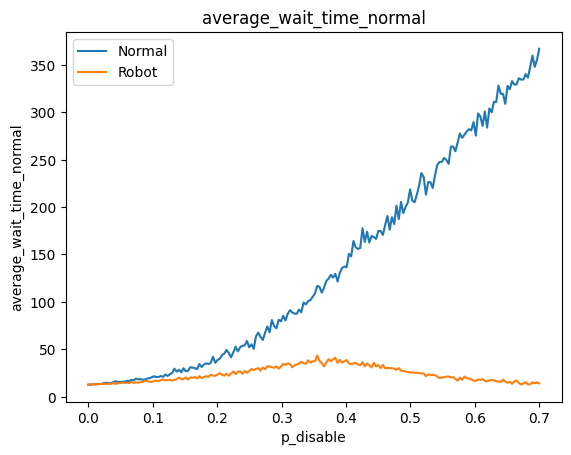

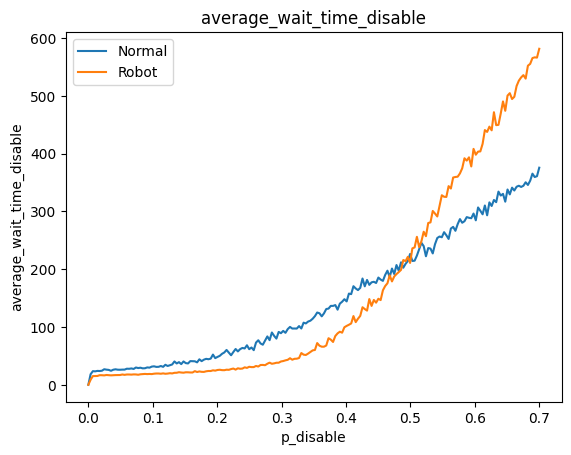

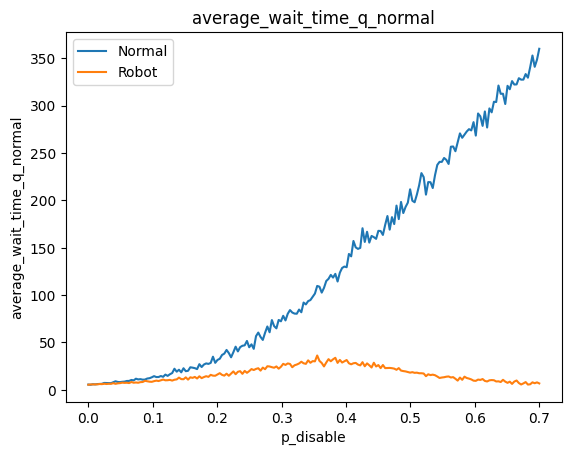

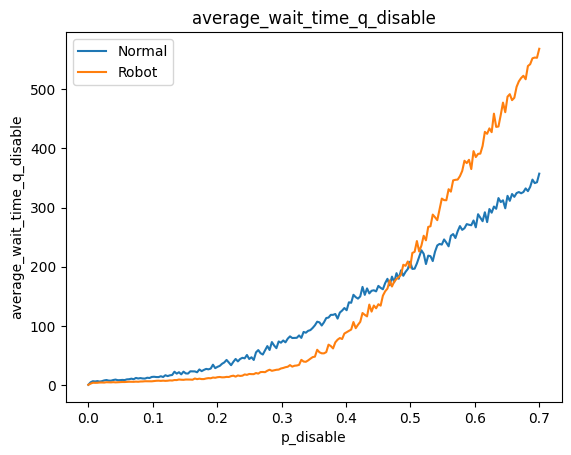

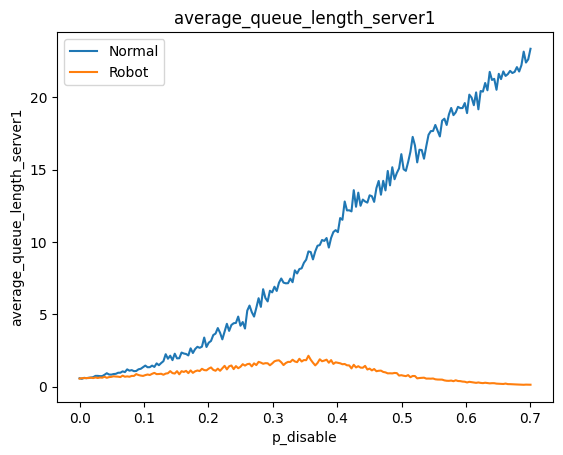

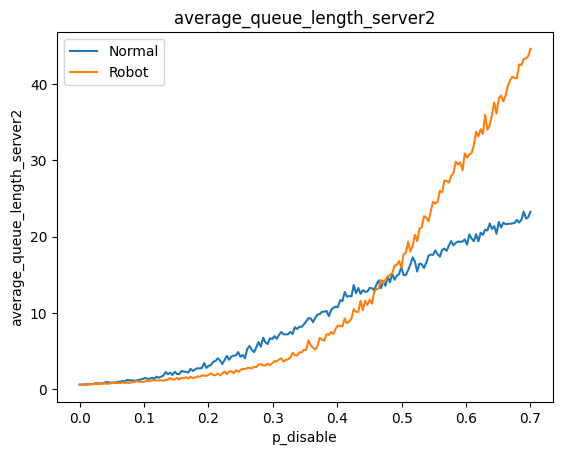

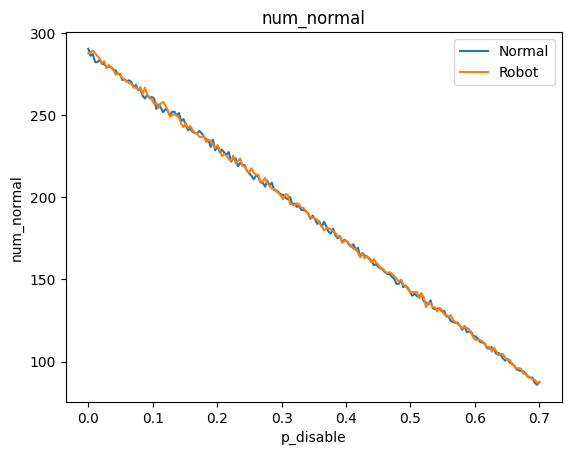

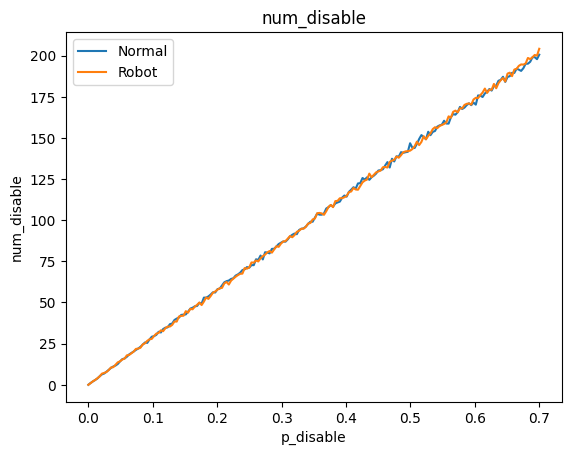

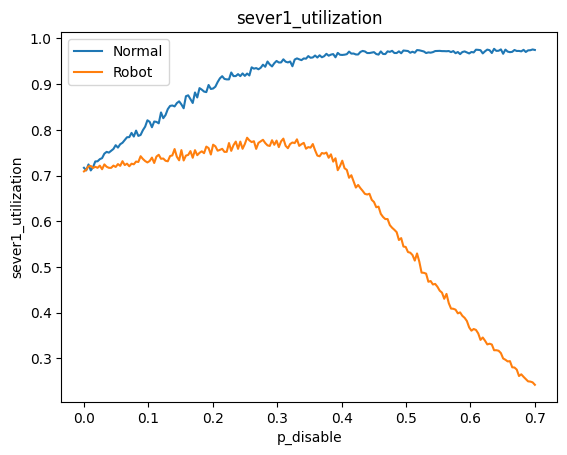

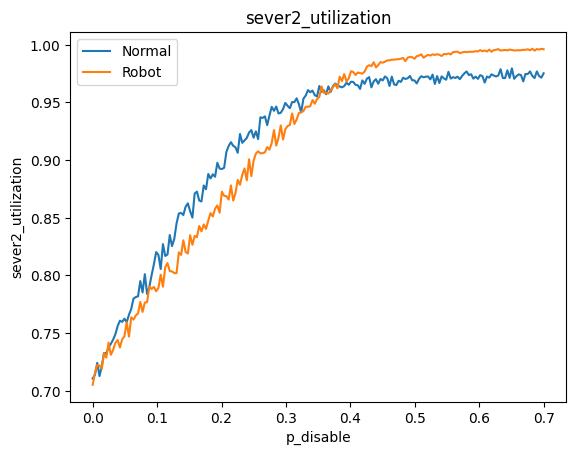

In [46]:
N = 100
T = 1440
p_disables = np.linspace(0.0, 0.7, 200)
p_dest = 0.5
p_error = 0.3
alpha = 0.7
lambd = 0.2

average_statistics_normals = []
average_statistics_robots = []

for p_disable in p_disables:
    average_statistics_normal, average_statistics_robot = compare_simulation(N, T, lambd, p_disable, p_dest, p_error,
                                                                             alpha=alpha, print_statistics=False)
    average_statistics_normals.append(average_statistics_normal)
    average_statistics_robots.append(average_statistics_robot)

plot_function(p_disables, average_statistics_normals, average_statistics_robots, param_label='p_disable')

##TODO

**now we consider all parameters constant and change p_dest in the range [0.0, 1.0]**

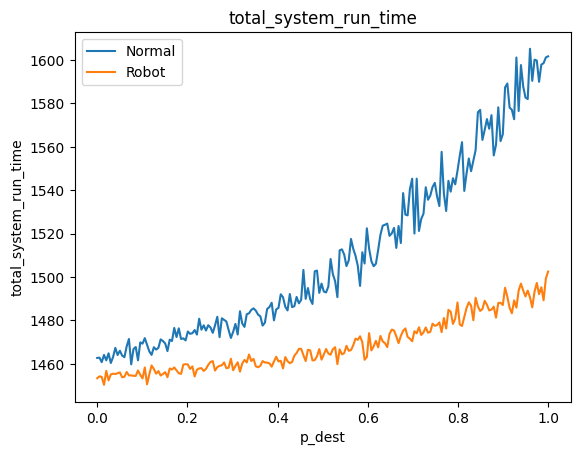

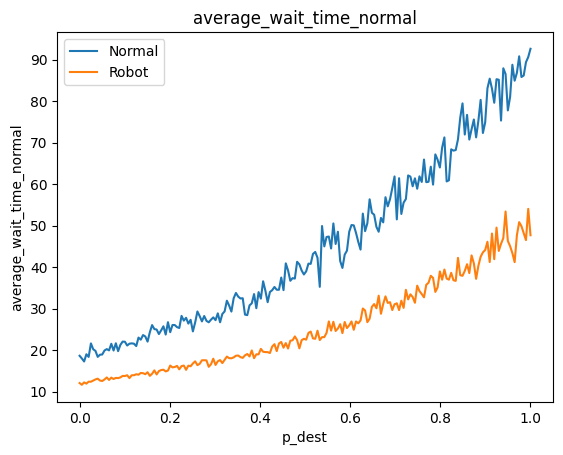

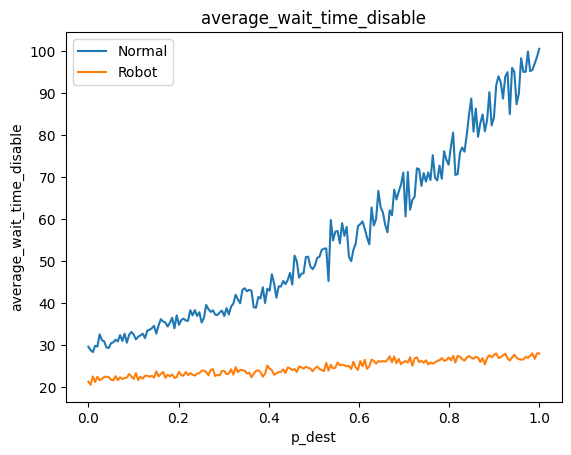

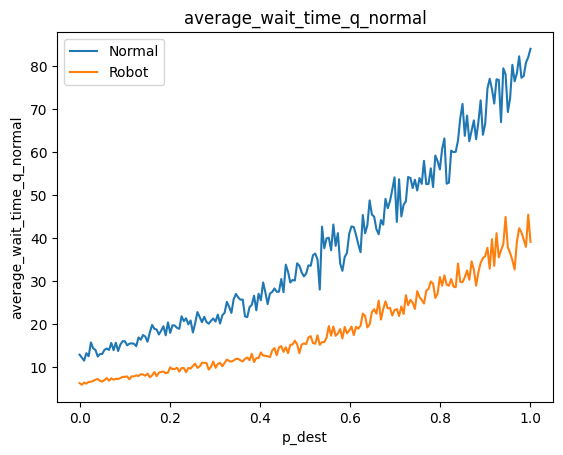

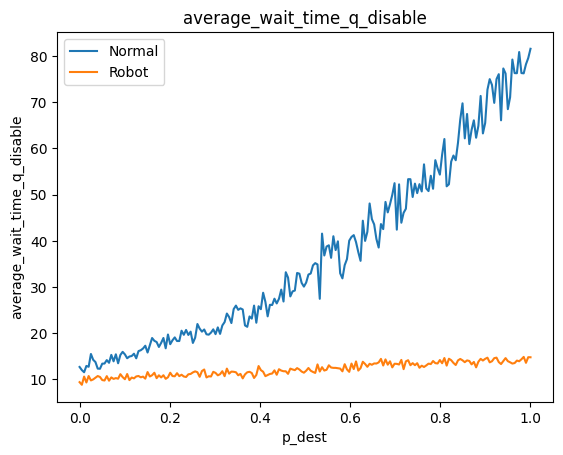

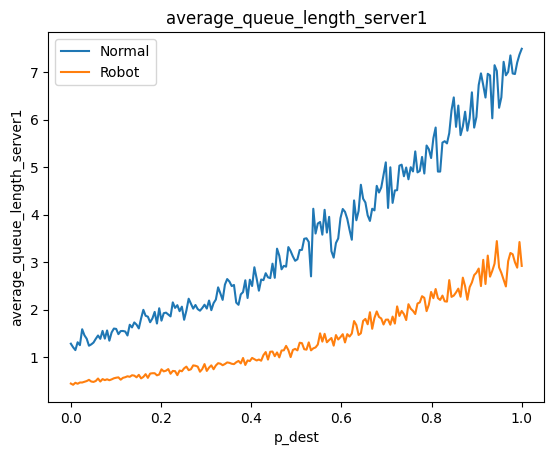

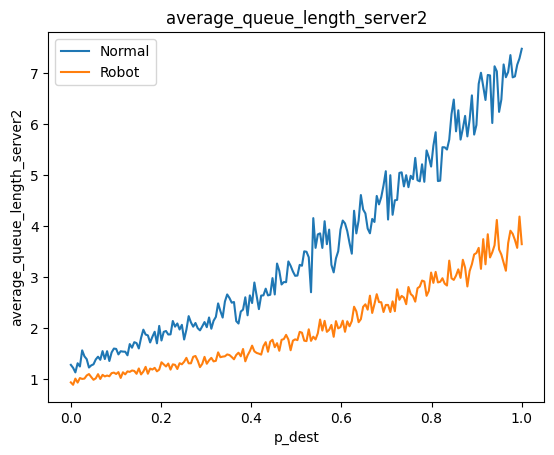

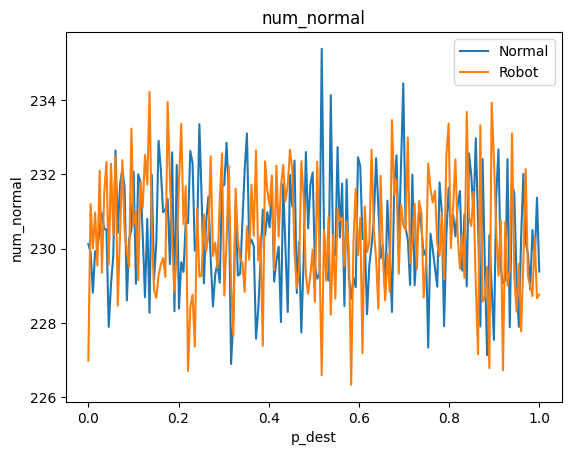

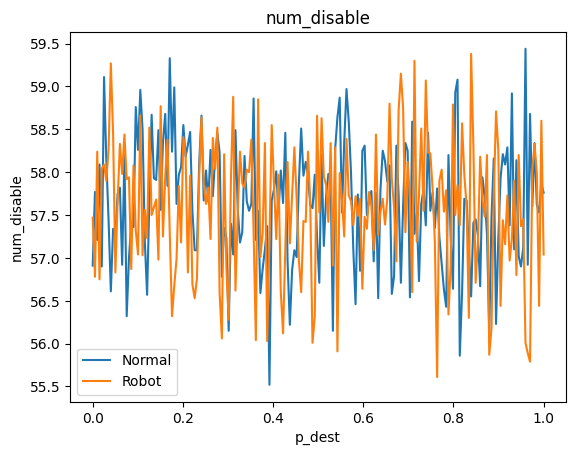

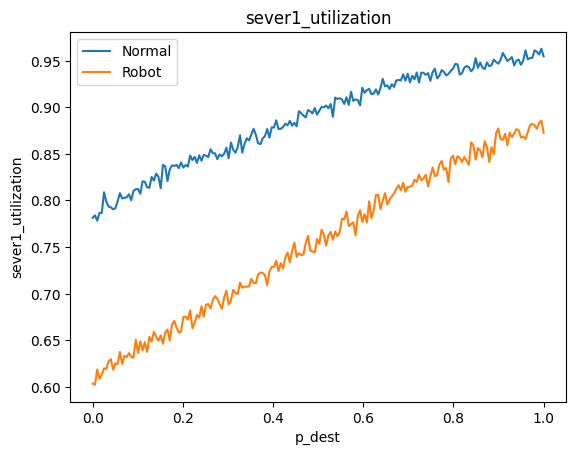

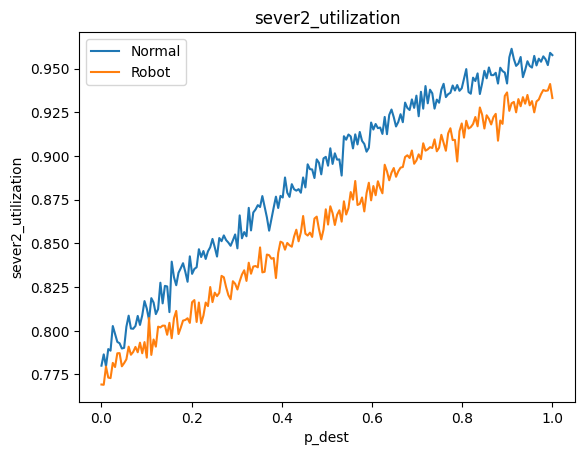

In [47]:
N = 100
T = 1440
p_disable = 0.2
p_dests = np.linspace(0.0, 1.0, 200)
p_error = 0.3
alpha = 0.7
lambd = 0.2

average_statistics_normals = []
average_statistics_robots = []

for p_dest in p_dests:
    average_statistics_normal, average_statistics_robot = compare_simulation(N, T, lambd, p_disable, p_dest, p_error,
                                                                             alpha=alpha, print_statistics=False)
    average_statistics_normals.append(average_statistics_normal)
    average_statistics_robots.append(average_statistics_robot)

plot_function(p_dests, average_statistics_normals, average_statistics_robots, param_label='p_dest')

**as the service time according to time_table is a little bit higher for destination 2, we expect that the average waiting times and ... goes higher when p_dest is higher. and plots confirm this.**

**now we consider all parameters constant and change p_error in the range [0.0, 0.9]**

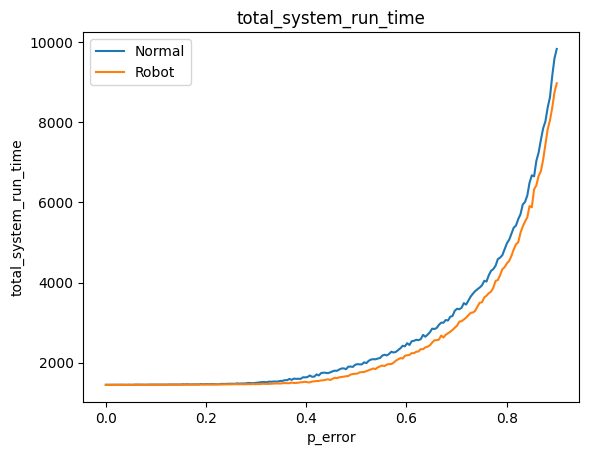

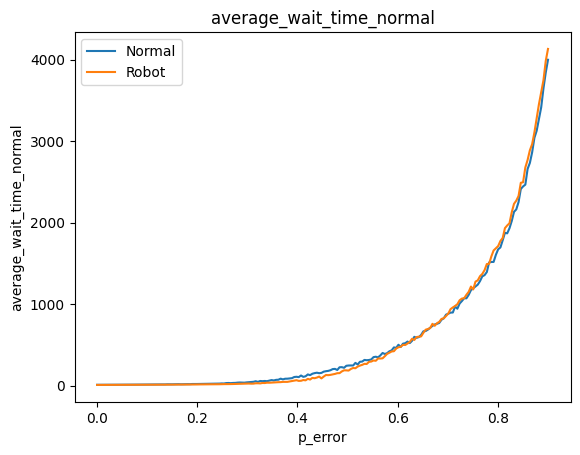

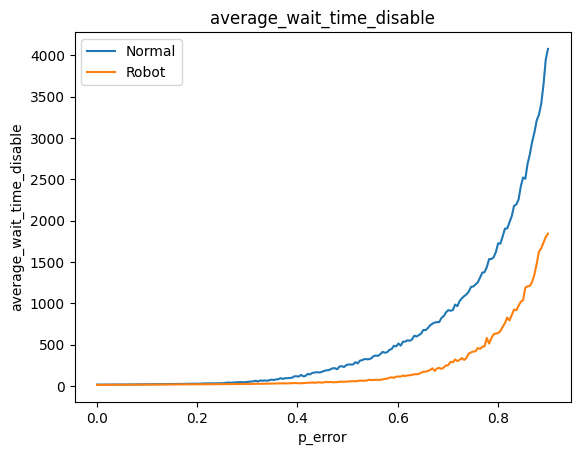

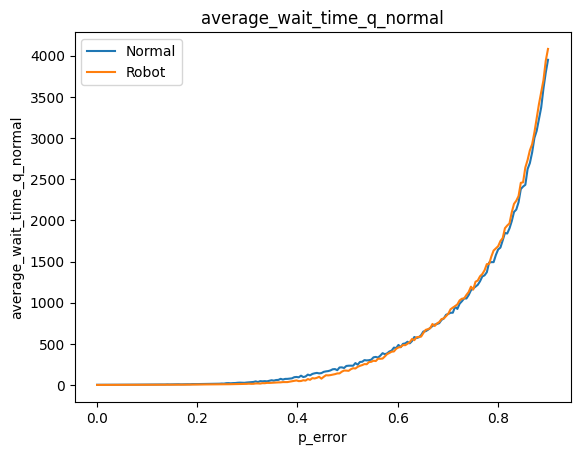

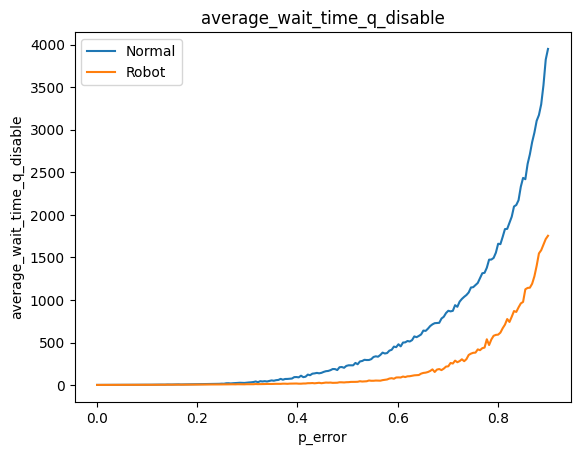

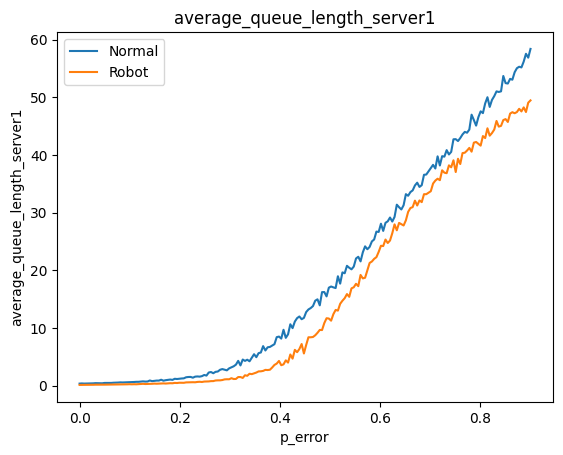

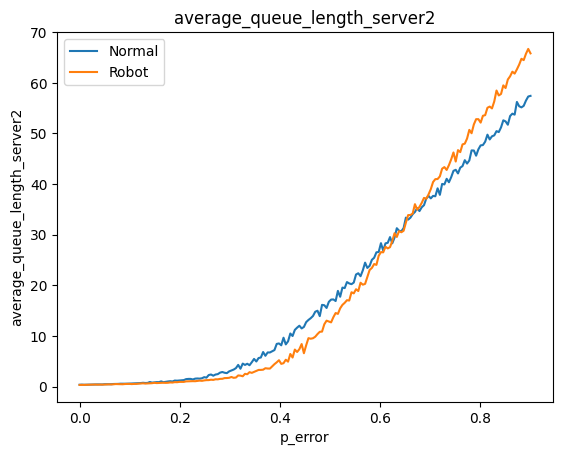

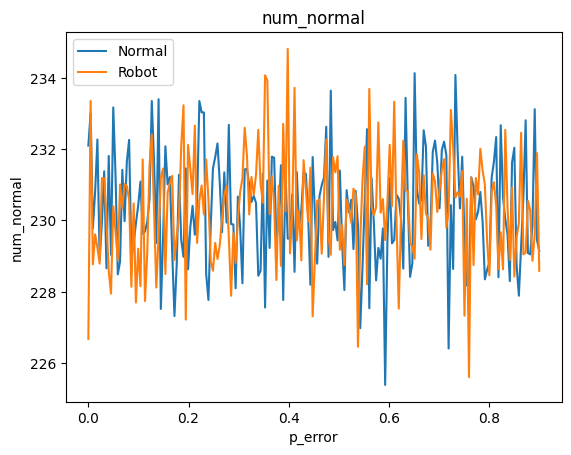

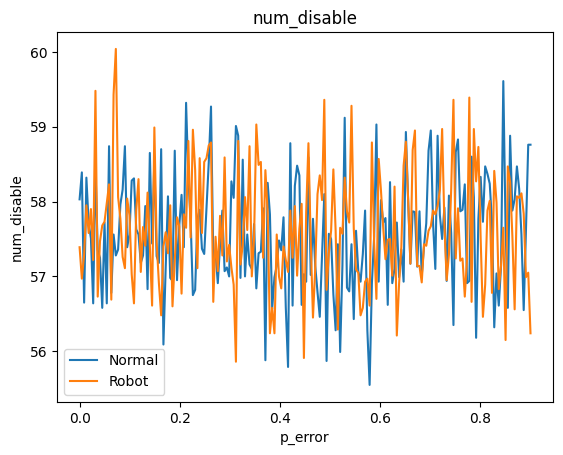

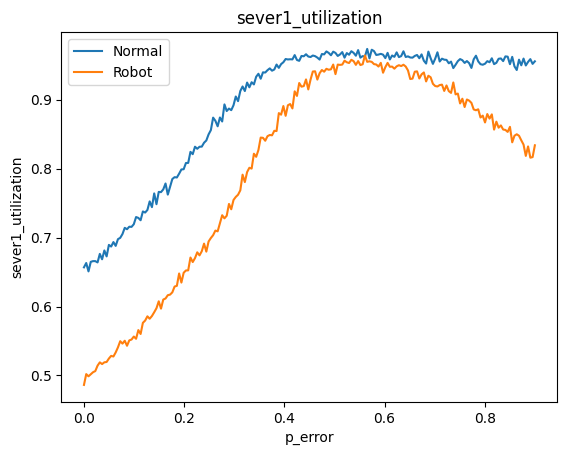

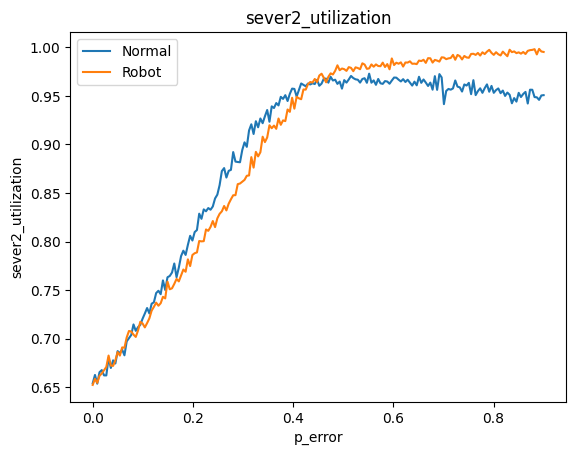

In [48]:
N = 100
T = 1440
p_disable = 0.2
p_dest = 0.5
p_errors = np.linspace(0.0, 0.9, 200)
alpha = 0.7
lambd = 0.2

average_statistics_normals = []
average_statistics_robots = []

for p_error in p_errors:
    average_statistics_normal, average_statistics_robot = compare_simulation(N, T, lambd, p_disable, p_dest, p_error,
                                                                             alpha=alpha, print_statistics=False)
    average_statistics_normals.append(average_statistics_normal)
    average_statistics_robots.append(average_statistics_robot)

plot_function(p_errors, average_statistics_normals, average_statistics_robots, param_label='p_error')

**as we can see when p_error is higher, the average waiting times and ... goes higher rapidly. it is because that thr service time is a function of $\frac{1}{1-p_{error}}$ and it is expected that plot of waiting statistics is a function of $\frac{1}{1-p_{error}}$**

**now we consider all parameters constant and change alpha in the range [0.1, 1.0]**

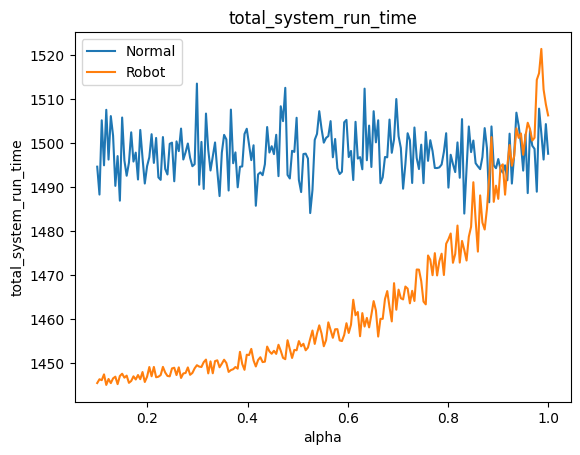

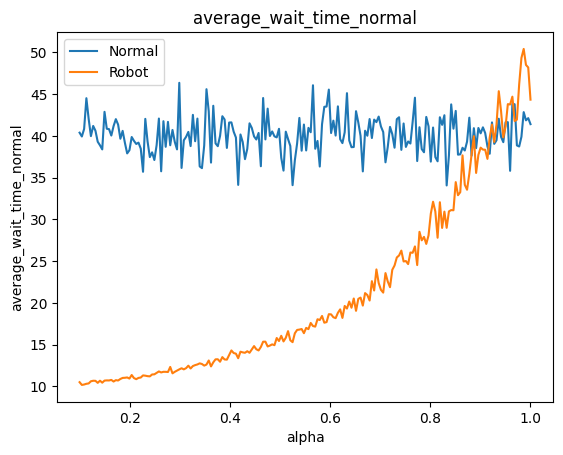

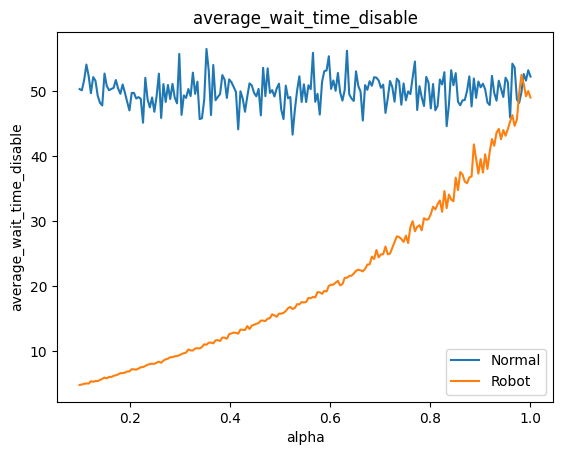

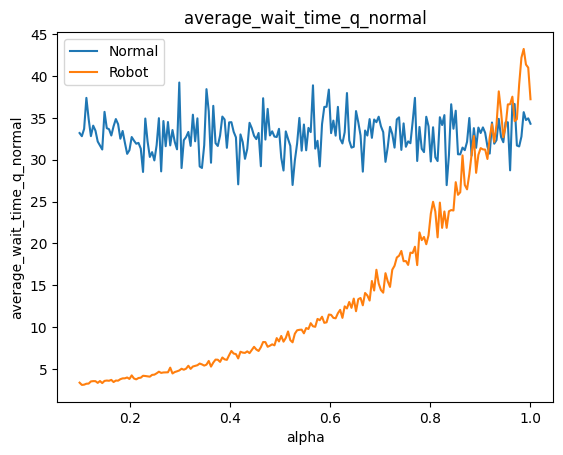

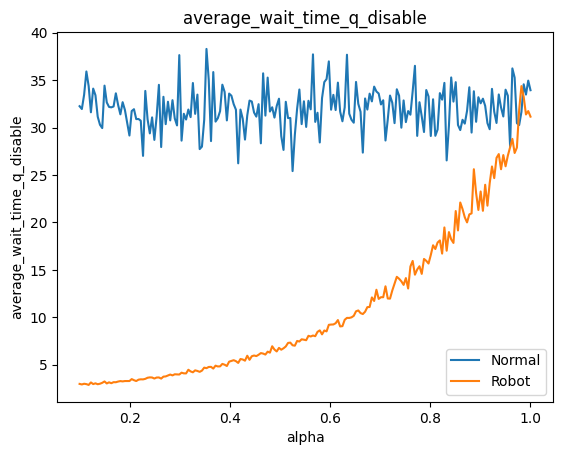

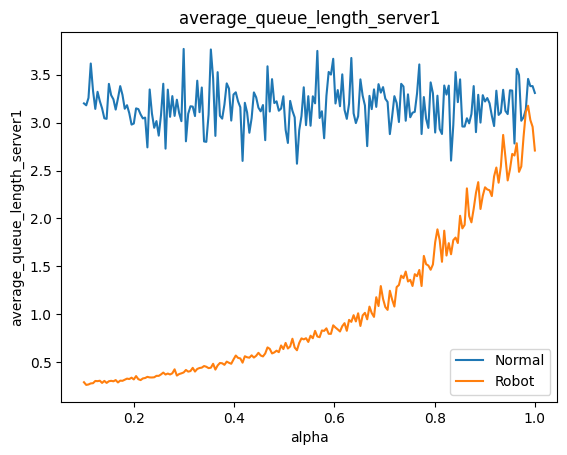

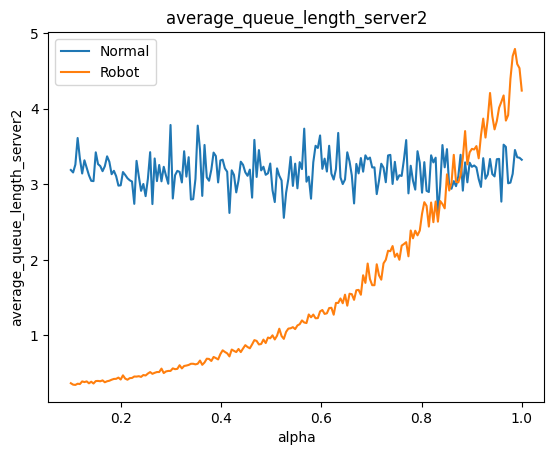

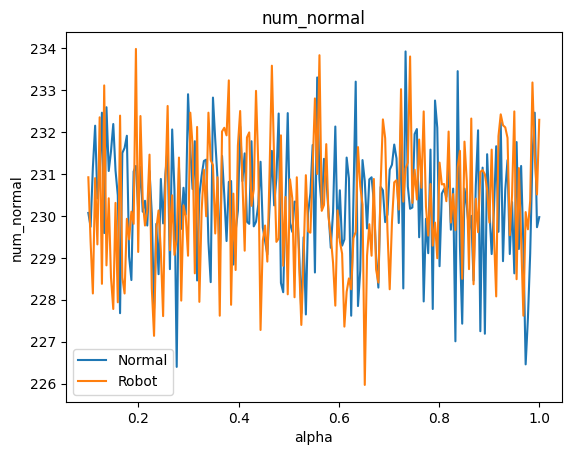

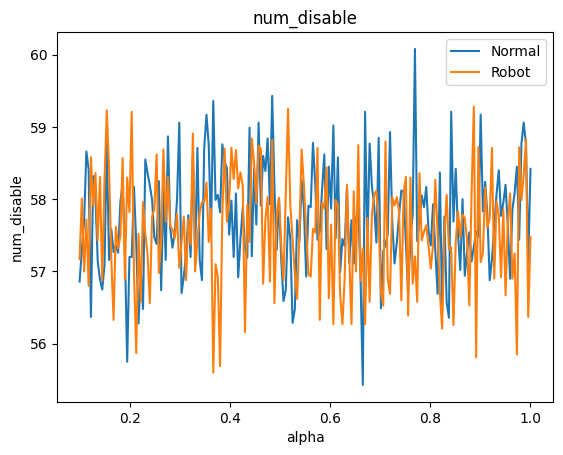

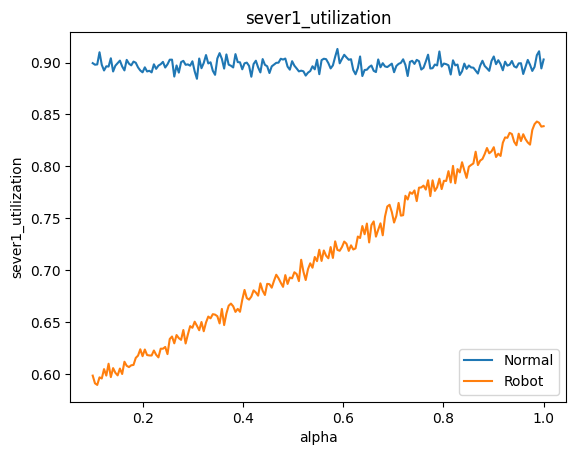

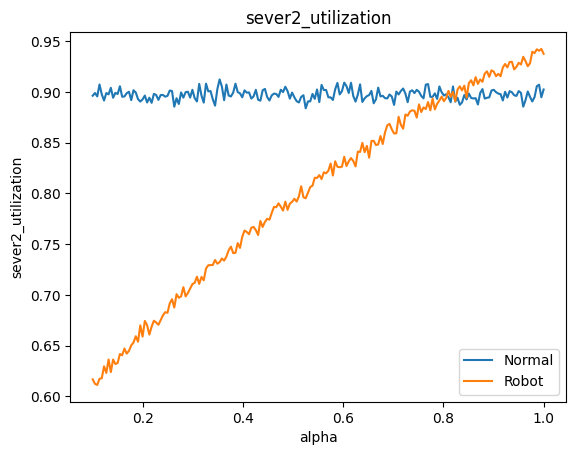

In [54]:
N = 100
T = 1440
p_disable = 0.2
p_dest = 0.5
p_error = 0.3
alphas = np.linspace(0.1, 1.0, 200)
lambd = 0.2

average_statistics_normals = []
average_statistics_robots = []

for alpha_ in alphas:
    average_statistics_normal, average_statistics_robot = compare_simulation(N, T, lambd, p_disable, p_dest, p_error,
                                                                             alpha=alpha_, print_statistics=False)
    average_statistics_normals.append(average_statistics_normal)
    average_statistics_robots.append(average_statistics_robot)

plot_function(alphas, average_statistics_normals, average_statistics_robots, param_label='alpha')

##TODO

**now we check the effect of priority_to_disabled parameter on system performance.
the difference between this parameter being True or False is that when it is False disabled patient still are just served in server 2 and can use robot assistance, but they are not served before normal people anymore**

In [63]:
N = 1000
T = 1440
p_disable = 0.2
p_dest = 0.5
p_error = 0.3
alpha = 0.7
lambd = 0.2


average_statistics_normal = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                                     disabled_server=False, alpha=alpha, log=False, print_statistics=False)
for i in range(N - 1):
    statistics = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                          disabled_server=False, alpha=alpha, log=False, print_statistics=False)
    for key, value in statistics.items():
        average_statistics_normal[key] += value

average_statistics_robot = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                                    disabled_server=True, alpha=alpha, log=False, print_statistics=False)
for i in range(N - 1):
    statistics = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                          disabled_server=True, alpha=alpha, log=False, print_statistics=False)
    for key, value in statistics.items():
        average_statistics_robot[key] += value
        
average_statistics_robot_priority_to_disabled_false = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                                    disabled_server=True, alpha=alpha, log=False, print_statistics=False, priority_to_disabled=False)

for i in range(N - 1):
    statistics = simulate(T=T, lambd=lambd, p_disable=p_disable, p_dest=p_dest, p_error=p_error,
                          disabled_server=True, alpha=alpha, log=False, print_statistics=False, priority_to_disabled=False)
    for key, value in statistics.items():
        average_statistics_robot_priority_to_disabled_false[key] += value


for key, value in average_statistics_normal.items():
    average_statistics_normal[key] /= N
for key, value in average_statistics_robot.items():
    average_statistics_robot[key] /= N
for key, value in average_statistics_robot_priority_to_disabled_false.items():
    average_statistics_robot_priority_to_disabled_false[key] /= N


print("Average Statistics Normal : ")
for key, value in average_statistics_normal.items():
    print(f"{key} : {value:.3f}")
print("\n")

print("Average Statistics Robot : ")
for key, value in average_statistics_robot.items():
    print(f"{key} : {value:.3f}")
print("\n")

print("Average Statistics Robot (Priority to Disabled False) : ")
for key, value in average_statistics_robot_priority_to_disabled_false.items():
    print(f"{key} : {value:.3f}")
    

Average Statistics Normal : 
total_system_run_time : 1495.618
average_wait_time_normal : 38.638
average_wait_time_disable : 48.660
average_wait_time_q_normal : 31.502
average_wait_time_q_disable : 30.527
average_queue_length_server1 : 3.027
average_queue_length_server2 : 3.030
num_normal : 229.891
num_disable : 57.394
sever1_utilization : 0.895
sever2_utilization : 0.896


Average Statistics Robot : 
total_system_run_time : 1463.820
average_wait_time_normal : 22.914
average_wait_time_disable : 24.748
average_wait_time_q_normal : 15.768
average_wait_time_q_disable : 12.083
average_queue_length_server1 : 1.197
average_queue_length_server2 : 1.803
num_normal : 230.273
num_disable : 57.421
sever1_utilization : 0.757
sever2_utilization : 0.864


Average Statistics Robot (Priority to Disabled False) : 
total_system_run_time : 1465.005
average_wait_time_normal : 18.553
average_wait_time_disable : 34.535
average_wait_time_q_normal : 11.417
average_wait_time_q_disable : 21.896
average_queue_len

**we can see that when we consider priority_to_disabled parameter as False, the average waiting times and ... goes higher for disabled patients and lower for normal patients. and other than this other statistics are almost the same.**